In [150]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

# Problem 1

In [220]:
# read data
reg = pd.read_csv('Regression.txt', sep=',', names = ['x1','x2','y'], header = None)
regtest = pd.read_csv('Regression-Test.txt', sep=',', names = ['x1','x2'], header = None)
reg.head()

,x1,x2,y
0,0.713,-0.345,-9.441
1,-0.245,1.684,2.795
2,1.388,-0.395,-6.032
3,1.556,-1.351,1.558
4,-1.162,-0.213,2.496


In [179]:
############# PART A ##################

# split into training and validation data
cut = 200
regtrain = reg.iloc[:cut-1]
regvali = reg.iloc[cut:]

# function creates predictor vector
def create_predictor(degree,data):
    # degree = degree of polynomial we want to train
    # data = data to transform into linear

    # transform data to become linear
    poly = PolynomialFeatures(degree=degree)
    phi = poly.fit_transform(data[['x1','x2']]) # size = 200x10 for poly(3)

    # create weights vector, wstar = inv((A'A))*A'*y
    wstar = np.matmul(np.matmul(np.linalg.pinv(np.matmul(phi.T,phi)),phi.T),data['y'])

    return wstar,phi,poly

def predict_new_labels(degree,wstar,data):
    # degree = degree of polynomial used to create predictor
    # wstar = predictor created using create_predictor
    # data = data used to create new labels

    # transform to linear
    poly = PolynomialFeatures(degree=degree)
    phi = poly.fit_transform(data[['x1','x2']])

    # create and return labels
    yhat = np.matmul(phi,wstar)
    return yhat

# compute validation loss and training loss
def compute_losses(phi, vali_data, ytrain, yvali):
    # validation loss
    n = vali_data.shape[0]
    vali_loss = 0
    for i in range(cut,250):
        vali_loss += (yvali[i-cut]-vali_data['y'][i])**2
    vali_loss *= n**(-1)

    # training loss
    m = phi.shape[0]
    train_loss = 0
    p = np.matmul(np.matmul(phi,np.matmul(np.linalg.pinv(np.matmul(phi.T,phi)),phi.T)),ytrain)

    for i in range(0,m):
        train_loss += (p[i] - ytrain[i])**2
    train_loss *= m**(-1)

    return vali_loss, train_loss
    



In [209]:
################# PART B #################

# dataframe for storing error values
df = pd.DataFrame(columns = ['degree', 'num_training_points', 'validation_loss', 'training_loss'])

for i in range(1,5):
    for j in range(20,201,20):

        # 2 variables for training
        degree = i
        num_points = j # anywhere from 1-200

        # run algorithms
        wstar, phi, poly = create_predictor(degree,regtrain[0:num_points])
        yhat = predict_new_labels(degree,wstar,regvali)
        vali_loss, train_loss = compute_losses(phi, regvali, regtrain['y'][0:num_points], yhat)

        new_row = pd.DataFrame([{'degree' : i, 'num_training_points' : j, 'validation_loss' : vali_loss, 'training_loss' : train_loss}])
        
        df = pd.concat([df,new_row],ignore_index = True)

Text(0.5, 0, 'number of training points used')

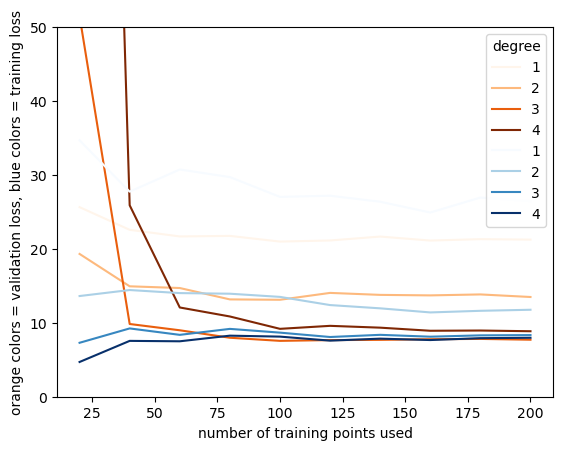

In [210]:
# plot validation loss and training loss as a function of degree and number of training points
sns.lineplot(data=df,x='num_training_points',y='validation_loss',hue='degree',palette="Oranges")
sns.lineplot(data=df,x='num_training_points',y='training_loss',hue='degree',palette="Blues")
plt.ylim([0, 50])
plt.ylabel('orange colors = validation loss, blue colors = training loss')
plt.xlabel('number of training points used')

based on the plot above, we can see slight overfitting starting at the degree 4 polynomial because the validation loss for degree 4 is greater than for degree 3

[-1.08833938 -0.78707616  0.08481832  1.13824927  2.32164572  0.85145475
  1.04612259 -0.01720518  0.20927236  0.97937953]


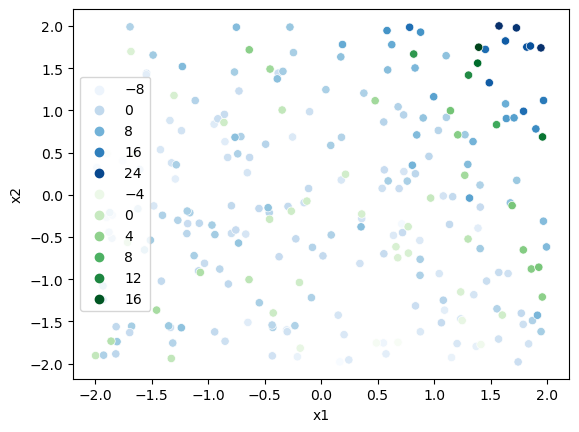

In [221]:
# plot the best estimator: degree 3, 200 training points
degree = 3
num_points = 200 # anywhere from 1-200

# run algorithms
wstar, phi, poly = create_predictor(degree,regtrain[0:num_points])
yhat = predict_new_labels(degree,wstar,regvali)
vali_loss, train_loss = compute_losses(phi, regvali, regtrain['y'][0:num_points], yhat)
sns.scatterplot(data=regtrain,x='x1',y='x2',hue='y',palette='Blues')
sns.scatterplot(x=regvali['x1'],y=regvali['x2'],hue=yhat,palette='Greens')
print(wstar)

in the plot above, blue shaded points are the training points and green shaded points are the validation points with my created labels. note that the shades match up fairly well over the graph

In [228]:
################## PART C ####################
# train algorithm on all 250 points then create labels for regression-test
degree = 3
wstar, phi, poly = create_predictor(degree,reg)
print(wstar)
yhat = predict_new_labels(degree,wstar,regtest)

np.savetxt('regression_test_labels', yhat, fmt='%.3f')

# sns.scatterplot(data=reg,x='x1',y='x2',hue='y',palette='Blues')
# sns.scatterplot(x=regtest['x1'],y=regtest['x2'],hue=yhat,palette='Greens')

[-0.87717106 -0.73113825 -0.05417522  1.11972915  2.34163107  0.71631244
  1.06935373 -0.07265017  0.21015105  1.04796512]


# Problem 2

In [3]:
# import packages
from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

# read data
d1 = pd.read_csv('Classify-2DwLabels-1.txt', sep=',', names = ['x1','x2','y'], header = None) # 2D, set 1
d2 = pd.read_csv('Classify-2DwLabels-2.txt', sep=',', names = ['x1','x2','y'], header = None) # 2D, set 2

# replace 0 label with -1
d1['y'] = d1['y'].replace(0,-1)
d2['y'] = d2['y'].replace(0,-1)

print(d1.head())
print(d1.shape)

     x1    x2  y
0 -0.22  0.59 -1
1 -0.35  0.12 -1
2  0.36  0.80  1
3 -0.34  0.10 -1
4  0.44  0.77  1
(250, 3)


In [139]:
############### PART A ###################
# using cvxopt to compute lamdas
def compute_lamdas(data):
    # data must be a pandas dataframe with 3 columns: 'x1', 'x2', and 'y'

    x = np.array(data[['x1','x2']])
    y = np.array(data['y'])
    rows = x.shape[0]
    y = y.reshape(-1,1)*1. # reshape and cast to float for cvxopt

    # create D matrix
    mat = y*x
    D = np.dot(mat,mat.T)

    # set up cvxopt, using cvxopt notation
    P = cvxopt_matrix(D)
    q = cvxopt_matrix(-np.ones(rows))
    G = cvxopt_matrix(-np.eye(rows,rows))
    h = cvxopt_matrix(np.zeros(rows))
    A = cvxopt_matrix(y.reshape(1,-1))
    b = cvxopt_matrix(np.zeros(1))

    # run solver
    cvxopt_solvers.options['show_progress'] = False
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    lamda = np.array(sol['x'])

    # ensure lamdas that should be 0 are actually 0
    lamda[lamda<0.00001] = 0

    return lamda

def compute_wstar(lamda,data):
    # lamda: vector of lamda values computed using compute_lamdas
    # data: data you want to separate    
    x = np.array(data[['x1','x2']])
    y = np.array(data['y'])

    # wstar = np.matmul((y*lamda).T , x)
    wstar = np.zeros(x.shape[1])
    for j in range(0, x.shape[1]):
        for i in range(0, x.shape[0]):
            wstar[j] += lamda[i]*y[i]*x[i][j]

    # compute geometric margin, w0star
    k = (lamda > 0.0001).flatten()
    
    w0star = y[k] - np.dot(x[k],wstar)

    return wstar,w0star

# predictor
def predictor(lamda,trainingdata,testingdata,w0star):
    xtrain = np.array(trainingdata[['x1','x2']])
    ytrain = np.array(trainingdata['y'])
    xtest = np.array(testingdata[['x1','x2']])

    # get nonzero values for lamda
    k = lamda.nonzero()
    k = np.array(k)[0]

    # create vector of labels
    y = np.zeros(xtest.shape[0])
    for i in range(0,y.shape[0]):
        sum = 0
        for j in k:
            sum += lamda[j]*ytrain[j]*xtrain[j]

        val = (np.dot(sum,xtest[i]) + w0star)[0]
        if val > 0:
            y[i] = 1
        else:
            y[i] = -1

    return y

wstar = [ 1.          8.4134615  -2.88461536]
geometric margin = 0.829326923244075
validation loss = 0.0
the light blue / orange points are the training data and the dark blue / yellow points are the validation data.
note that all the validation points were correctly classified


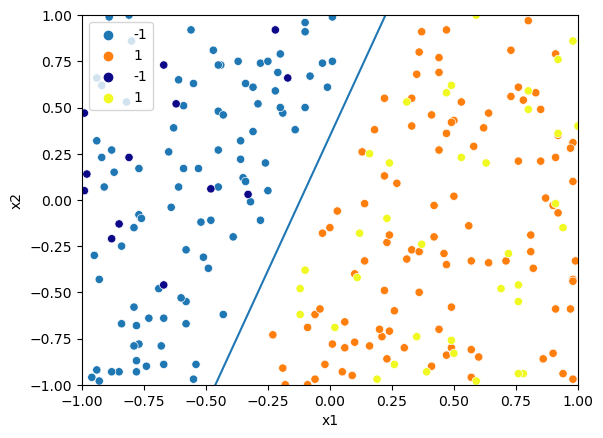

In [140]:
################ PART B, DATASET 1 #################
# split into training and validation data
cut = 200
d1train = d1.iloc[:cut-1]
d1vali = d1.iloc[cut:]

# find separator
lamda = compute_lamdas(d1train)
wstar, w0star = compute_wstar(lamda,d1train)

wstar = np.insert(wstar,0,1)
print(f"wstar = {wstar}")

# plot result
a = np.linspace(-1,1,100)

sns.lineplot(x = a,y = (-wstar[0]-wstar[1]*a)/wstar[2])    
sns.scatterplot(data = d1train, x="x1", y="x2", hue="y", palette = "tab10")
plt.xlim([-1,1])
plt.ylim([-1,1])

# geometric margin
print(f"geometric margin = {w0star[0]}")

# predictor and validation loss
y = predictor(lamda,d1train,d1vali,w0star)
y = np.int0(y)

n = d1vali.shape[0]
vali_loss = 0
for i in range(cut,250):
    vali_loss += (y[i-cut]-d1vali['y'][i])**2
vali_loss *= n**(-1)
print(f"validation loss = {vali_loss}")

sns.scatterplot(x=d1vali["x1"], y=d1vali["x2"], hue=y, palette = "plasma")
print("the light blue / orange points are the training data and the dark blue / yellow points are the validation data.")
print("note that all the validation points were correctly classified")


the light blue / orange points are the training data and the dark blue / yellow points are the validation data.
note that all the validation points were correctly classified. validation loss = 0.

wstar = [  1.         -19.41074524  -9.87868284]
geometric margin = 1.0693240876274999
validation loss = 0.0
the light blue / orange points are the training data and the dark blue / yellow points are the validation data.
note that all the validation points were correctly classified


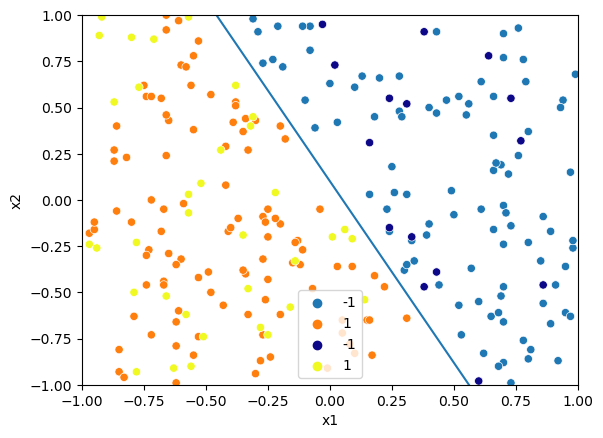

In [141]:
################ PART B, DATASET 2 #################
# split into training and validation data
cut = 200
d2train = d2.iloc[:cut-1]
d2vali = d2.iloc[cut:]

# find separator
lamda = compute_lamdas(d2train)
wstar, w0star = compute_wstar(lamda,d2train)

wstar = np.insert(wstar,0,1)
print(f"wstar = {wstar}")

# plot result
a = np.linspace(-1,1,100)

sns.lineplot(x = a,y = (-wstar[0]-wstar[1]*a)/wstar[2])    
sns.scatterplot(data = d2train, x="x1", y="x2", hue="y", palette = "tab10")
plt.xlim([-1,1])
plt.ylim([-1,1])

# geometric margin
print(f"geometric margin = {w0star[0]}")

# predictor and validation loss
y = predictor(lamda,d2train,d2vali,w0star)
y = np.int0(y)

n = d2vali.shape[0]
vali_loss = 0
for i in range(cut,250):
    vali_loss += (y[i-cut]-d2vali['y'][i])**2
vali_loss *= n**(-1)
print(f"validation loss = {vali_loss}")

sns.scatterplot(x=d2vali["x1"], y=d2vali["x2"], hue=y, palette = "plasma")
print("the light blue / orange points are the training data and the dark blue / yellow points are the validation data.")
print("note that all the validation points were correctly classified")


the light blue / orange points are the training data and the dark blue / yellow points are the validation data.
note that all the validation points were correctly classified. validation loss = 0

### PART C

I didn't have enough time to numerically compare my results from Hard SVM vs. the Perceptron algorithm, but there's a clear visual difference. Hard SVM gives a separator with an equal distance between the two labelled sets whereas the Perceptron algorithm had a separator right against one of the groupings, leaving no margin for error

# Problem 3

In [142]:
# read data
d3 = pd.read_csv('Classify-2D-wLabels-3.txt', sep=',', names = ['x1','x2','y'], header = None) # 2D, set 3

# replace 0 label with -1
d3['y'] = d3['y'].replace(0,-1)

In [143]:
# modify functions from problem 2 for problem 3

# using cvxopt to compute lamdas
def compute_lamdas_3(data,y):

    x = data
    rows = x.shape[0]
    y = y.reshape(-1,1)*1. # reshape and cast to float for cvxopt

    # create D matrix
    mat = y*x
    D = np.dot(mat,mat.T)

    # set up cvxopt, using cvxopt notation
    P = cvxopt_matrix(D)
    q = cvxopt_matrix(-np.ones(rows))
    G = cvxopt_matrix(-np.eye(rows,rows))
    h = cvxopt_matrix(np.zeros(rows))
    A = cvxopt_matrix(y.reshape(1,-1))
    b = cvxopt_matrix(np.zeros(1))

    # run solver
    cvxopt_solvers.options['show_progress'] = False
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    lamda = np.array(sol['x'])

    # ensure lamdas that should be 0 are actually 0
    lamda[lamda<0.001] = 0

    return lamda

def compute_wstar_3(lamda,data,y):
    # lamda: vector of lamda values computed using compute_lamdas
    # data: data you want to separate  
    x = data  

    # wstar = np.matmul((y*lamda).T , x)
    wstar = np.zeros(x.shape[1])
    for j in range(0, x.shape[1]):
        for i in range(0, x.shape[0]):
            wstar[j] += lamda[i]*y[i]*x[i][j]

    # compute geometric margin, w0star
    k = (lamda > 0.001).flatten()
    
    w0star = y[k] - np.dot(x[k],wstar)

    return wstar,w0star

# predictor
def predictor_3(lamda,trainingdata,testingdata,w0star,ytrain):
    xtrain = trainingdata
    xtest = testingdata

    # get nonzero values for lamda
    k = lamda.nonzero()
    k = np.array(k)[0]

    # create vector of labels
    y = np.zeros(xtest.shape[0])
    for i in range(0,y.shape[0]):
        sum = 0
        for j in k:
            sum += lamda[j]*ytrain[j]*xtrain[j]

        val = (np.dot(sum,xtest[i]) + w0star)[0]
        if val > 0:
            y[i] = 1
        else:
            y[i] = -1

    return y

wstar = [-1.54423507e-04  1.91055513e+00  4.20403864e+00  6.97593865e+01
 -5.63942915e+01 -1.26633844e+02 -5.69365280e+01 -4.42747024e+01
 -3.39298508e+01  2.73077986e+01]
validation loss = 0.24


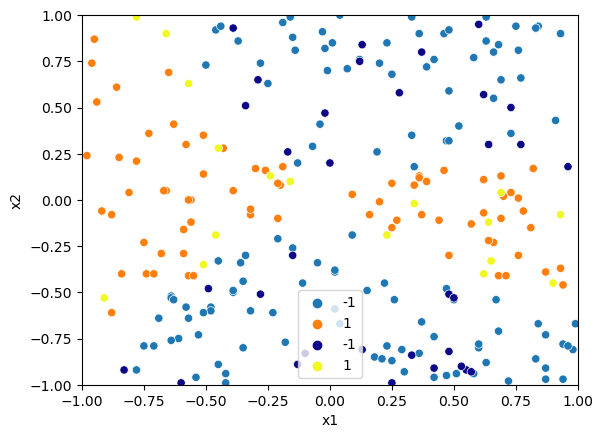

In [145]:
############# PART A and B, DEGREE 3 ################
# split into training and validation data
cut = 200
d3train = d3.iloc[:cut-1]
d3vali = d3.iloc[cut:]

# linearize data using create_predictor function from problem 1
degree = 3
wstar,phi,poly = create_predictor(degree,d3train)
# print(poly.get_feature_names(['x1','x2']))

# find separator
lamda = compute_lamdas_3(phi,np.array(d3train['y']))
wstar, w0star = compute_wstar_3(lamda,phi,np.array(d3train['y']))

# print wstar
# wstar = np.insert(wstar,0,1)
print(f"wstar = {wstar}")


# plot result
x1 = np.linspace(-1,1,100)
x2 = np.linspace(-1,1,100)

w = wstar
# sns.lineplot(x = x2,y = w[0]+w[1]*x1+w[2]*x2+w[3]*x1**2+w[4]*x1*x2+w[5]*x2**2+w[6]*x1**3+w[7]*x2*2*x1**2+w[8]*x1*x2**2+w[9]*x2**3)    
sns.scatterplot(data = d3train, x="x1", y="x2", hue="y", palette = "tab10")
plt.xlim([-1,1])
plt.ylim([-1,1])

# print(w0star)

wstar_v,phi_v,poly_v = create_predictor(degree, d3vali)
y = predictor_3(lamda,phi,phi_v,w0star,np.array(d3train['y']))
y = np.int0(y)
sns.scatterplot(x=d3vali["x1"], y=d3vali["x2"], hue=y, palette = "plasma")

# validation loss
n = d3vali.shape[0]
vali_loss = 0
for i in range(cut,250):
    vali_loss += (y[i-cut]-d3vali['y'][i])**2
vali_loss *= n**(-1)
print(f"validation loss = {vali_loss}")


for the graph above, the light blue / orange points are the training data and the dark blue / yellow points are the validation data.
note that most of the validation points were correctly classified. I could not figure out how to draw the decision boundary on the graph, but based on the validation loss, we know the classifier works (but is not 100% correct). validation loss = 0.24

[-9.09853236e-05  1.01362623e+00  3.08680697e+00  4.21519378e+01
 -3.65273597e+01 -1.00753390e+02 -6.41505422e+01 -1.59661515e+01
  8.41018730e+00  1.84850971e+01  4.72425870e+01  1.55594926e+01
 -5.10752641e+00 -1.42528812e+01 -2.30199498e+01]
wstar = [-9.09853236e-05  1.01362623e+00  3.08680697e+00  4.21519378e+01
 -3.65273597e+01 -1.00753390e+02 -6.41505422e+01 -1.59661515e+01
  8.41018730e+00  1.84850971e+01  4.72425870e+01  1.55594926e+01
 -5.10752641e+00 -1.42528812e+01 -2.30199498e+01]
validation loss = 0.08


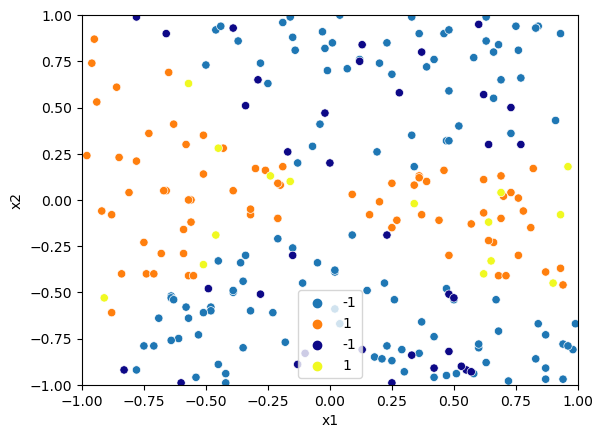

In [149]:
############# PART A and B, DEGREE 4 ################
# split into training and validation data
cut = 200
d3train = d3.iloc[:cut-1]
d3vali = d3.iloc[cut:]

# linearize data using create_predictor function from problem 1
degree = 4
wstar,phi,poly = create_predictor(degree,d3train)
# print(poly.get_feature_names(['x1','x2']))

# find separator
lamda = compute_lamdas_3(phi,np.array(d3train['y']))
wstar, w0star = compute_wstar_3(lamda,phi,np.array(d3train['y']))

# print wstar
# wstar = np.insert(wstar,0,1)
print(f"wstar = {wstar}")


# plot result
x1 = np.linspace(-1,1,100)
x2 = np.linspace(-1,1,100)

w = wstar
# sns.lineplot(x = x2,y = w[0]+w[1]*x1+w[2]*x2+w[3]*x1**2+w[4]*x1*x2+w[5]*x2**2+w[6]*x1**3+w[7]*x2*2*x1**2+w[8]*x1*x2**2+w[9]*x2**3)    
sns.scatterplot(data = d3train, x="x1", y="x2", hue="y", palette = "tab10")
plt.xlim([-1,1])
plt.ylim([-1,1])

# print(w0star)

wstar_v,phi_v,poly_v = create_predictor(degree, d3vali)
y = predictor_3(lamda,phi,phi_v,w0star,np.array(d3train['y']))
y = np.int0(y)
sns.scatterplot(x=d3vali["x1"], y=d3vali["x2"], hue=y, palette = "plasma")

# validation loss
n = d3vali.shape[0]
vali_loss = 0
for i in range(cut,250):
    vali_loss += (y[i-cut]-d3vali['y'][i])**2
vali_loss *= n**(-1)
print(f"validation loss = {vali_loss}")


validation loss = 0.08. for some reason, there are a couple points being misclassified. I'm guessing they're right near the boundary. depending on which datapoints were chosen to be training vs. validation, there might never be 0 validation loss. this is because the points that might make up the boundary (with lambda values nonzero) could be in the validation dataset

also note that the first 10 terms of wstar for the degree 4 polynomial estimator are identical to wstar for the degree 3 polynomial

# END HOMEWORK